In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import densenet, MobileNetV3Large, efficientnet, nasnet, MobileNetV2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.9.1
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [16]:
for dirpath, dirnames, filenames in os.walk('Patches_BreakHis_train_val'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 12444 imagens em  Patches_BreakHis_train_val\train_set\benign.
Existem 12444 imagens em  Patches_BreakHis_train_val\train_set\malignant.
Existem 2160 imagens em  Patches_BreakHis_train_val\validation_set\benign.
Existem 2160 imagens em  Patches_BreakHis_train_val\validation_set\malignant.


In [4]:
train_dir = 'Patches_BreakHis_train_val/train_set/'
val_dir = 'Patches_BreakHis_train_val/validation_set/'
test_dir = 'Patches_BreCaHAD_test/dataset_malignant_only/'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

Found 24888 images belonging to 2 classes.
Found 4320 images belonging to 2 classes.
Found 5401 images belonging to 2 classes.


In [6]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.nasnet.preprocess_input(xi)

basemodel = nasnet.NASNetMobile(include_top=False,
                                 weights='imagenet',
                                 input_tensor = xi,
                                 input_shape=IMG_SHAPE,
                                 pooling='max')

x = Dense(128, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [10]:
'''# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.nasnet.preprocess_input(xi)

basemodel = nasnet.NASNetMobile(include_top=False,
                                 weights='imagenet',
                                 input_tensor = xi,
                                 input_shape=IMG_SHAPE,
                                 pooling='max')

x = Dense(256, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)'''

In [11]:
#model.summary()

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [7]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [8]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [9]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [10]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
778/778 [==============================] - 92s 100ms/step - loss: 0.5031 - accuracy: 0.7833 - val_loss: 0.5144 - val_accuracy: 0.7588
Epoch 2/40
778/778 [==============================] - 90s 116ms/step - loss: 0.3706 - accuracy: 0.8374 - val_loss: 0.4875 - val_accuracy: 0.7764
Epoch 3/40
778/778 [==============================] - 90s 115ms/step - loss: 0.3294 - accuracy: 0.8576 - val_loss: 0.4505 - val_accuracy: 0.7912
Epoch 4/40
778/778 [==============================] - 91s 117ms/step - loss: 0.3063 - accuracy: 0.8634 - val_loss: 0.4317 - val_accuracy: 0.8067
Epoch 5/40
778/778 [==============================] - 88s 114ms/step - loss: 0.2845 - accuracy: 0.8744 - val_loss: 0.4332 - val_accuracy: 0.8086
Epoch 6/40
778/778 [==============================] - 90s 115ms/step - loss: 0.2662 - accuracy: 0.8826 - val_loss: 0.4273 - val_accuracy: 0.8190
Epoch 7/40
778/778 [==============================] - 89s 115ms/step - loss: 0.2555 - accuracy: 0.8896 - val_loss: 0.4119 - val_ac

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [11]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  773


In [12]:
# Descongelar as 40% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.4):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [13]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [14]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [15]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 23/100
778/778 [==============================] - 113s 131ms/step - loss: 0.1629 - accuracy: 0.9359 - val_loss: 0.3279 - val_accuracy: 0.8701
Epoch 24/100
778/778 [==============================] - 101s 129ms/step - loss: 0.1266 - accuracy: 0.9513 - val_loss: 0.2965 - val_accuracy: 0.8940
Epoch 25/100
778/778 [==============================] - 100s 128ms/step - loss: 0.1047 - accuracy: 0.9606 - val_loss: 0.3408 - val_accuracy: 0.8789
Epoch 26/100
778/778 [==============================] - 98s 126ms/step - loss: 0.0861 - accuracy: 0.9685 - val_loss: 0.2985 - val_accuracy: 0.8968
Epoch 27/100
778/778 [==============================] - 99s 127ms/step - loss: 0.0697 - accuracy: 0.9750 - val_loss: 0.2686 - val_accuracy: 0.9076
Epoch 28/100
778/778 [==============================] - 101s 129ms/step - loss: 0.0648 - accuracy: 0.9771 - val_loss: 0.2414 - val_accuracy: 0.9139
Epoch 29/100
778/778 [==============================] - 100s 129ms/step - loss: 0.0523 - accuracy: 0.9835 - val_lo

In [16]:
model.save("PatchNonNorma_SaveModel/PatchNonNorma_SaveModel_NASNetMobile")

INFO:tensorflow:Assets written to: PatchNonNorma_SaveModel/PatchNonNorma_SaveModel_NASNetMobile\assets


INFO:tensorflow:Assets written to: PatchNonNorma_SaveModel/PatchNonNorma_SaveModel_NASNetMobile\assets


In [17]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

169/169 [==============================] - 14s 79ms/step - loss: 0.0892 - accuracy: 0.9704
Test accuracy: 0.970
Test loss: 0.089


# GRADCAM

In [17]:
test_dir = 'Patches_BreCaHAD_test/dataset_malignant_only'
data_dir_test = pathlib.Path(test_dir)

class_names = np.array(sorted([item.name for item in data_dir_test.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


In [18]:
# Carrega o modelo
model = load_model("PatchNonNorma_SaveModel/PatchNonNorma_SaveModel_NASNetMobile")

In [19]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), model.layers))[-1].name
print(last_conv_layer_name) 

normal_conv_1_12


In [20]:
def get_img_array(img_path, size):

    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    array = tf.keras.utils.img_to_array(img)

    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(last_conv_layer_name).output, model.output])
           
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [21]:
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    preds = model.predict(img_array)
    top_pred_index = tf.argmax(preds[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [22]:
def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("gray")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) 
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) 


    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)


    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

# Gerar dataset

In [23]:
def loading_json(filen='Patches_BreCaHAD_test/groundTruth_malignant_only/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):

            f = open(filen+item)
            data = json.load(f)
            
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            x_y = []
            for j, points in enumerate(data['tumor']):
                values_i_j = []
                
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))

                x_y.append(values_i_j)

            annot_points[item.split('.')[0]] = x_y

            f.close()
            
    return tumor_cells, annot_points

In [24]:
def getting_probs(filen='Patches_BreCaHAD_test/dataset_malignant_only/malignant/'):
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [25]:
def checking_points(annot_points, lst_heatmaps):
    
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1    
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [26]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [27]:
df = generating_dataset()

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


In [28]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,1))

Acurácia de Classificação (%):  97.0


In [29]:
mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model}. STD_Deviation: {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 19.48. STD_Deviation: 23.65. With Median: 12.5

Min.: 0.0 | Max.: 100.0


(array([2422.,  570.,  749.,  507.,  251.,  383.,  161.,   50.,   22.,
         126.]),
 array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0],
       dtype=object),
 <BarContainer object of 10 artists>)

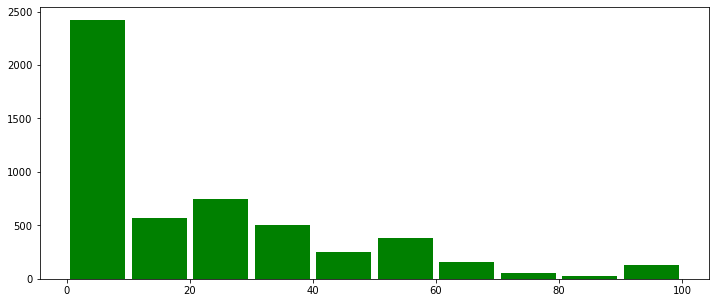

In [30]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9)

### TESTE

In [31]:
def display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     


    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) 
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) 

    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)

    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

In [48]:
df.head(5)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Patch_0__Case_1-01,6,malignant,99.98,3,50.0
1,Patch_0__Case_1-03,6,malignant,100.0,2,33.33
2,Patch_0__Case_1-04,4,malignant,99.98,2,50.0
3,Patch_0__Case_1-05,3,malignant,99.99,0,0.0
4,Patch_0__Case_1-06,4,malignant,100.0,1,25.0


In [32]:
df[df['Interpret. Region Accuracy (%)'] == df['Interpret. Region Accuracy (%)'].max()]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
43,Patch_0__Case_14-07,1,malignant,99.97,1,100.0
50,Patch_0__Case_15-09,3,malignant,94.91,3,100.0
78,Patch_0__Case_3-09,2,malignant,99.95,2,100.0
130,Patch_10__Case_12-11,1,malignant,99.97,1,100.0
143,Patch_10__Case_14-02,1,malignant,99.95,1,100.0
...,...,...,...,...,...,...
5235,Patch_8__Case_5-08,1,malignant,99.9,1,100.0
5241,Patch_8__Case_6-06,1,malignant,100.0,1,100.0
5327,Patch_9__Case_16-03,1,malignant,99.98,1,100.0
5332,Patch_9__Case_16-10,1,malignant,99.9,1,100.0


In [49]:
case='Patch_0__Case_1-06'

In [50]:
IMG = 'Patches_BreCaHAD_test/dataset_malignant_only/malignant/'+case+'.png'
PATH1 = 'Patches_BreCaHAD_test/patches_groundTruth_display/'+case+'.png'

1/1 [==============================] - 0s 38ms/step


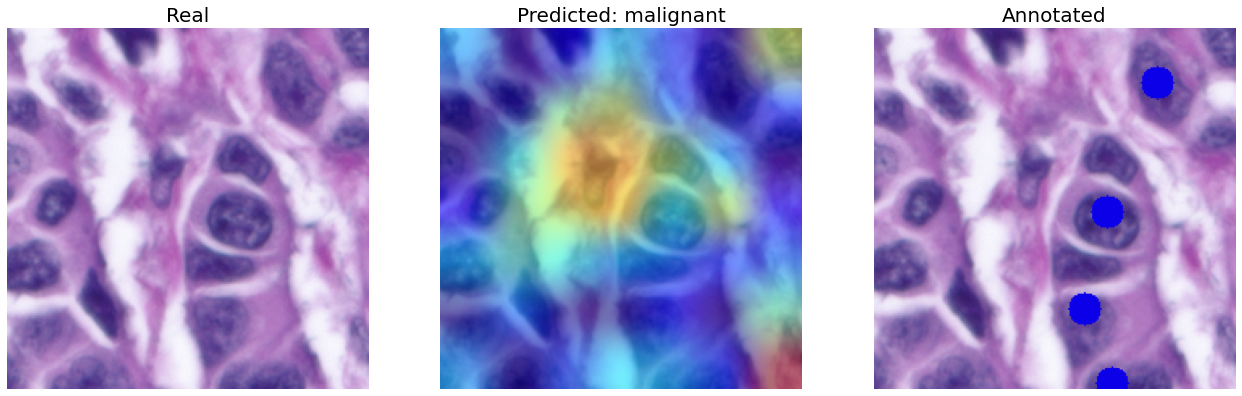

In [51]:

img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

plt.figure(figsize=(22,22))
plt.subplot(1,3,1)
plt.title('Real',fontsize=20)
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.title(f'Predicted: {class_1}', fontsize=20)
plt.axis(False)
result=display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
plt.subplot(1,3,3)
plt.title('Annotated', fontsize=20)
plt.axis(False)
plt.imshow(img)

In [36]:
'''plt.figure(figsize=(10,10))

plt.imshow(result, cmap='gray')'''

"plt.figure(figsize=(10,10))\n\nplt.imshow(result, cmap='gray')"

In [37]:
'''# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)'''

"# inverting result mask\nplt.figure(figsize=(20,20))\ndata1 = cv.imread(PATH1)\ndata1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)\nfinal = cv.bitwise_and(data1, data1, mask = result)\nfinal = cv.cvtColor(final, cv.COLOR_RGB2GRAY)\nplt.subplot(1,2,1)\nplt.imshow(final, cmap='gray')\nplt.subplot(1, 2, 2)\nplt.imshow(data1)"

In [ ]:
'''plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')'''